In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline


In [3]:
import timeit

def create_df():
    header = ['id', 'tweet', 'target']

    df = pd.read_csv('sentiment_tweets3.csv', names=header, header=0, encoding='latin-1')

    df = df.drop('id', axis=1)

    return df

timeit.Timer(create_df).timeit(number=1) * 1000

23.012399999998934

In [4]:
header = ['id', 'tweet', 'target']

tweet_df = pd.read_csv('sentiment_tweets3.csv', names=header, header=0, encoding='latin-1')
suicide_df = pd.read_csv('Suicide_Detection.csv', names=header, header=0, encoding='latin-1')
tweet_df = tweet_df.drop('id', axis=1)
suicide_df = suicide_df.drop('id', axis=1)
suicide_df['target'] = suicide_df['target'].map({'suicide': 1, 'non-suicide': 0})

df = pd.concat([tweet_df, suicide_df], ignore_index=True, sort=False)

df

,tweet,target
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
242383,If you don't like rock then your not going to ...,0
242384,You how you can tell i have so many friends an...,0
242385,pee probably tastes like salty teaðð¦â¼ï...,0
242386,The usual stuff you find hereI'm not posting t...,1


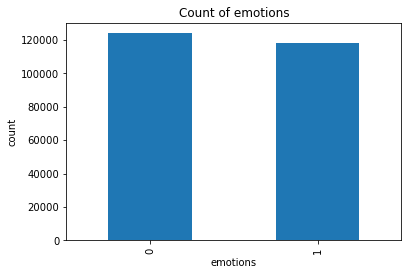

In [5]:
df['target'].value_counts().sort_index().plot(kind='bar', title='Count of emotions')
plt.xlabel("emotions")
plt.ylabel("count")

plt.show()

In [6]:
example = df['tweet'][2].lower()
print(example)

@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zogfqvh2me8 


In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

In [9]:
raw_token = word_tokenize(example)
raw_token

['@',
 'comeagainjen',
 'http',
 ':',
 '//twitpic.com/2y2lx',
 '-',
 'http',
 ':',
 '//www.youtube.com/watch',
 '?',
 'v=zogfqvh2me8']

# Clean the Dataset

In [12]:
import string
import re
stopwords = set(nltk.corpus.stopwords.words('english'))

# token = [WordNetLemmatizer().lemmatize(w) for w in stopwords_removed_token]

def clean_words(words):
    table = str.maketrans('', '', string.punctuation)
    splitted_words = words.split()

    lower_split = [w for w in splitted_words if "@" not in w]
    lower_split = [w for w in lower_split if "#" not in w]
    lower_split = [w for w in lower_split if "http" not in w]
    
    lower_split = [w.strip() for w in lower_split]
    lower_split = [w for w in lower_split if not w.isdigit()]
    lower_split = [w for w in lower_split if w.isalpha()]

    lower_split = [w.translate(table) for w in lower_split]

    stopwords_removed_token = [w for w in lower_split if not w in stopwords]
    token = [PorterStemmer().stem(w) for w in stopwords_removed_token]

    token = " ".join(str(x) for x in token)
    return token

df['tweet'] = df['tweet'].apply(lambda x: clean_words(x))

df.head(10)

,tweet,target
0,real good missssssssss,0
1,read manga,0
2,,0
3,need send account i even refer those support,0
4,add me on,0
5,good time tonight though,0
6,someon alreadi fiber home mean least regular,0
7,possibl nice,0
8,nite twittervil workout,0
9,sweet dream,0


In [17]:
x_train, x_test, y_train, y_test = train_test_split(df['tweet'], df['target'], test_size=0.3, random_state=100, shuffle=True)

# XGBoost

In [19]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [23]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
count_vect = CountVectorizer()
count_xgb_clf = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', XGBClassifier())
])

count_xgb_clf.fit(x_train, y_train)

Pipeline(steps=[('count_vect', CountVectorizer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [25]:
cv_result = cross_validate(count_xgb_clf, x_test, y_test, scoring=['f1', 'recall', 'accuracy', 'precision', 'neg_log_loss', 'balanced_accuracy'], cv=6)
print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())
print(cv_result['test_neg_log_loss'].mean())
print(cv_result['test_balanced_accuracy'].mean())

cv_result

0.8881522746588827
0.8605309124260283
0.8943026301970077
0.9176149014219588
-0.2650529137440299
0.893490881670683


{'fit_time': array([3.76941705, 3.80717897, 3.70090914, 3.98948097, 3.82542706,
        3.8039639 ]),
 'score_time': array([0.77191424, 0.73204875, 0.77212024, 0.76164055, 0.75818038,
        0.75327396]),
 'test_f1': array([0.88648649, 0.89038579, 0.88260527, 0.8887723 , 0.88828907,
        0.89237473]),
 'test_recall': array([0.86009136, 0.86093724, 0.85281678, 0.85989848, 0.86311337,
        0.86632826]),
 'test_accuracy': array([0.89257426, 0.89661716, 0.88935644, 0.89504084, 0.89413318,
        0.8980939 ]),
 'test_precision': array([0.91455298, 0.92192029, 0.91455007, 0.91965255, 0.91497758,
        0.92003594]),
 'test_neg_log_loss': array([-0.26631584, -0.25700706, -0.27340345, -0.26070576, -0.26791819,
        -0.26496719]),
 'test_balanced_accuracy': array([0.89179475, 0.89576094, 0.88847958, 0.89419469, 0.89338629,
        0.89732905])}

# CatBoost

In [26]:
%pip install CatBoost

Note: you may need to restart the kernel to use updated packages.


In [27]:
from catboost import CatBoostClassifier

In [30]:
count_vect = CountVectorizer()
count_cat_clf = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', CatBoostClassifier())
])

count_cat_clf.fit(x_train, y_train)

Learning rate set to 0.092252
0:	learn: 0.6320523	total: 404ms	remaining: 6m 44s
1:	learn: 0.5848416	total: 788ms	remaining: 6m 33s
2:	learn: 0.5485384	total: 1.17s	remaining: 6m 30s
3:	learn: 0.5201544	total: 1.55s	remaining: 6m 26s
4:	learn: 0.4977687	total: 1.92s	remaining: 6m 21s
5:	learn: 0.4800905	total: 2.3s	remaining: 6m 20s
6:	learn: 0.4653351	total: 2.66s	remaining: 6m 17s
7:	learn: 0.4532908	total: 3.03s	remaining: 6m 15s
8:	learn: 0.4438756	total: 3.4s	remaining: 6m 14s
9:	learn: 0.4351373	total: 3.78s	remaining: 6m 14s
10:	learn: 0.4277137	total: 4.15s	remaining: 6m 13s
11:	learn: 0.4216789	total: 4.52s	remaining: 6m 12s
12:	learn: 0.4162277	total: 4.89s	remaining: 6m 11s
13:	learn: 0.4113619	total: 5.3s	remaining: 6m 13s
14:	learn: 0.4067771	total: 5.68s	remaining: 6m 12s
15:	learn: 0.4028732	total: 6.04s	remaining: 6m 11s
16:	learn: 0.3989445	total: 6.41s	remaining: 6m 10s
17:	learn: 0.3956309	total: 6.78s	remaining: 6m 10s
18:	learn: 0.3925110	total: 7.14s	remaining: 6m

Pipeline(steps=[('count_vect', CountVectorizer()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x0000021C65201EE0>)])

In [31]:
cv_result = cross_validate(count_cat_clf, x_test, y_test, scoring=['f1', 'recall', 'accuracy', 'precision', 'neg_log_loss', 'balanced_accuracy'], cv=6)
print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())
print(cv_result['test_neg_log_loss'].mean())
print(cv_result['test_balanced_accuracy'].mean())

cv_result

Learning rate set to 0.059435
0:	learn: 0.6531283	total: 197ms	remaining: 3m 16s
1:	learn: 0.6196475	total: 362ms	remaining: 3m
2:	learn: 0.5906740	total: 530ms	remaining: 2m 56s
3:	learn: 0.5676019	total: 693ms	remaining: 2m 52s
4:	learn: 0.5467916	total: 859ms	remaining: 2m 51s
5:	learn: 0.5284071	total: 1.02s	remaining: 2m 49s
6:	learn: 0.5128696	total: 1.19s	remaining: 2m 48s
7:	learn: 0.5008120	total: 1.36s	remaining: 2m 49s
8:	learn: 0.4891655	total: 1.53s	remaining: 2m 48s
9:	learn: 0.4793027	total: 1.7s	remaining: 2m 48s
10:	learn: 0.4700619	total: 1.86s	remaining: 2m 47s
11:	learn: 0.4619006	total: 2.02s	remaining: 2m 46s
12:	learn: 0.4546882	total: 2.18s	remaining: 2m 45s
13:	learn: 0.4485345	total: 2.37s	remaining: 2m 46s
14:	learn: 0.4429123	total: 2.53s	remaining: 2m 46s
15:	learn: 0.4378934	total: 2.7s	remaining: 2m 45s
16:	learn: 0.4331344	total: 2.85s	remaining: 2m 45s
17:	learn: 0.4285103	total: 3.02s	remaining: 2m 44s
18:	learn: 0.4249616	total: 3.22s	remaining: 2m 46

{'fit_time': array([153.57024932, 157.58449435, 159.31678295, 171.18839359,
        159.60055161, 149.39936829]),
 'score_time': array([0.85662723, 0.91210842, 0.98618531, 0.87417817, 0.83321476,
        0.81844354]),
 'test_f1': array([0.8917855 , 0.89506931, 0.88816713, 0.89845185, 0.89355008,
        0.89718322]),
 'test_recall': array([0.86229064, 0.86296735, 0.85586195, 0.86903553, 0.86497462,
        0.87038917]),
 'test_accuracy': array([0.89793729, 0.90132013, 0.89488449, 0.90420002, 0.89949666,
        0.90271475]),
 'test_precision': array([0.92336957, 0.9296519 , 0.92300675, 0.92992939, 0.92407809,
        0.92567932]),
 'test_neg_log_loss': array([-0.25738437, -0.24597126, -0.26431403, -0.2496542 , -0.25663662,
        -0.25439486]),
 'test_balanced_accuracy': array([0.89708187, 0.90039976, 0.89394805, 0.90335333, 0.89866544,
        0.90193641])}